In [1]:
import json
import os
import re
from datetime import datetime, timedelta
from urllib.parse import urlparse
import time
import yaml

import bs4
from bs4 import BeautifulSoup
import requests

import dotenv

import IPython
from IPython.display import HTML, Markdown, display

from atproto import Client

import PIL
from PIL import Image


In [2]:
print(f"requests        {requests.__version__}")
print(f"BeautifulSoup   {bs4.__version__}")


requests        2.32.3
BeautifulSoup   4.13.3


In [3]:
dotenv.load_dotenv()


True

# Load posts from BlueSky and format for Substack or a blog post
for now I share the interesting stuff on bluesky and then use this code to grab latest BlueSky 'tweets' and format a [Substack post](https://skynetandchill.com)


In [4]:
client = Client(base_url='https://bsky.social')
client.login(os.environ['BSKY_USERNAME'], os.environ['BSKY_SECRET'])

mydid = {"did":"did:plc:qomkdnxrqw3gkbytdxea5z65"}

data = client.get_author_feed(
    actor=mydid['did'],
    filter='posts_and_author_threads',
    limit=50,
)


In [5]:
def remove_urls(text):
    # Regular expression to match URLs
    url_pattern = r'https?://\S+|www\.\S+'
    # Substitute found URLs with an empty string
    clean_text = re.sub(url_pattern, '', text)
    return clean_text


In [6]:
def rawfetchurl(url, timeout=60):
    """get url using requests with specified timeout. return response object, status, content-type"""
    try:
        response = requests.get(url, timeout=timeout)
    except httplib.BadStatusLine:
        log("Bad response (?) fetching url %s " % url)
        response = None
    except requests.Timeout:
        log("Timeout fetching url %s " % url)
        response = None
    except requests.ConnectionError as e:
        log("Connection error (%s) fetching url %s " % (str(e), url))
        response = None
    except requests.TooManyRedirects:
        log("Too many redirects fetching url %s " % url)
        response = None
    except requests.exceptions.MissingSchema:
        log("Missing schema url %s " % url)
        response = None
    except requests.exceptions.InvalidSchema:
        log("Invalid schema url %s " % url)
        response = None
    except requests.exceptions.InvalidURL as e:
        log("Invalid url %s, %s" % (url, str(e)))
        response = None
    except ValueError as e:
        # don't log url because possibly malformed url
        log("ValueError, url ?: ? ")
        response = None
    except httplib.IncompleteRead as e:
        log("IncompleteRead, url %s: %s " % (url, str(e)))
        response = None
    except urllib3.exceptions.SSLError as e:
        log("SSLError, url %s: %s " % (url, str(e)))
        response = None
    except requests.exceptions.ContentDecodingError as e:
        log("SSLError, url %s: %s " % (url, str(e)))
        response = None
    except requests.exceptions.ChunkedEncodingError as e:
        log("ChunkedEncodingError, url %s: %s " % (url, str(e)))
        response = None
    except UnicodeEncodeError as e:
        log("UnicodeEncodeError, url %s: %s " % (url, str(e)))
        response = None
    except OpenSSL.SSL.SysCallError as e:
        log("OpenSSL.SSL.SysCallError, url %s: %s " % (url, str(e)))
        response = -1
    except OpenSSL.SSL.ZeroReturnError as e:
        log("OpenSSL.SSL.ZeroReturnError, url %s: %s " % (url, str(e)))
        response = -1

    # except requests.packages.urllib3.exceptions.DecodeError as e:
    #     utilLog("DecodeError, url %s: %s " % (url, str(e)))
    #     response = None

    return response



In [7]:
def resize_and_crop(input_image_path, output_image_path, desired_height=240):
    # Load the image
    with Image.open(input_image_path) as img:
        img = img.convert('RGB')

        # Calculate the new width maintaining the aspect ratio
        aspect_ratio = img.width / img.height
        new_width = int(desired_height * aspect_ratio)

        # Resize the image
        resized_img = img.resize((new_width, desired_height))

        # Save the resized image
        resized_img.save(output_image_path)


In [8]:
# attempt to remove traiing inline URLs

def truncate_last_occurrence(text: str) -> str:
    # Find trailing occurrence of a space followed by any sequence of characters followed by 3 periods
    pattern = r'\s+\S+\.{3}$'
    return re.sub(pattern, '', text)

# Example text for testing

example_text = """Elon Musk says we'll run out of power capacity to run all the AI chips in 2025
newatlas.com/technology/e..."""

# Truncate the last occurrence
print(truncate_last_occurrence(example_text))


Elon Musk says we'll run out of power capacity to run all the AI chips in 2025


In [9]:
def get_og_tags(url):
    """get a dict of Open Graph og: tags such as title in the HEAD of a URL"""
    retdict = {}
    try:
        response = requests.get(url)
        if response.status_code == 200:
            soup = BeautifulSoup(response.content, "html.parser")
            head = soup.head
            if head:
                og_tags = head.find_all(
                    property=lambda prop: prop and prop.startswith("og:")
                )
                for tag in og_tags:
                    if "content" in tag.attrs:
                        retdict[tag["property"]] = tag["content"]

                page_title = ""
                title_tag = soup.find("title")
                if title_tag:
                    page_title = title_tag.text
                    if page_title:
                        retdict["title"] = page_title
        return retdict
    except requests.RequestException as e:
        log(f"Error fetching {url}: {e}")
    return retdict


url = "https://druce.ai"
get_og_tags(url)

{'og:site_name': 'Druce.ai',
 'og:title': 'Druce.ai',
 'og:type': 'website',
 'og:description': "Druce's Blog on Machine Learning, Tech, Markets and Economics",
 'og:url': 'https://druce.ai/',
 'title': 'Druce.ai'}

In [10]:
def delete_files(outputdir):

    # Iterate over all files in the directory
    for filename in os.listdir(outputdir):
        if filename.startswith('.'):
            continue
        file_path = os.path.join(outputdir, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.remove(file_path)  # Remove the file
            elif os.path.isdir(file_path):
                # If you want to remove subdirectories as well, use os.rmdir() here
                pass
        except Exception as e:
            log(f'Failed to delete {file_path}. Reason: {e}')
            


 x <br /> 



 <br /> 


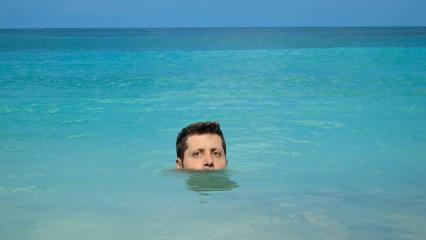

[AI slopaganda is big business. Where's my 6-figure-per month bonanza?](https://www.ft.com/content/24218775-57b1-4e9f-ba64-266a3239cf27)

___

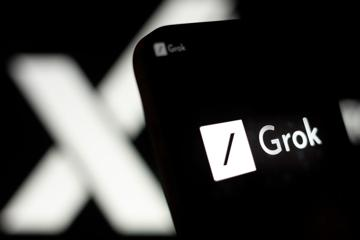

[Grok adds Grok Studio with a canvas-like tool for creating docs and apps](https://techcrunch.com/2025/04/15/grok-gains-a-canvas-like-tool-for-creating-docs-and-apps/) - TechCrunch

___

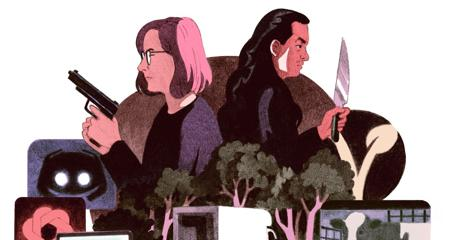

[Vegan rationalist AI cult leaves a trail of dead bodies. Weird AI cults are probably going to be a big thing.](https://www.thecut.com/article/milo-youngblut-max-snyder-zivians-cult-murders.html) - The Cut

___

[Nvidia to take a \\$5.5b trade war charge b/c it built a lot of nerfed H20 chips, US will no longer let them be exported to China, China no longer wants them](https://finance.yahoo.com/news/nvidia-stock-dives-as-chipmaker-sees-55-billion-hit-from-surprise-china-chip-controls-130319576.html)

___

[There is no \\$500b commitment, unsurprisingly](https://www.barrons.com/livecoverage/tariffs-trump-us-china/card/trump-will-fast-track-permits-for-nvidia-s-u-s-ai-buildout-GEZrxejaQhiQ1B8XoIFE?ref=biztoc.com)

___

[AI-powered deception: Emerging fraud threats and countermeasures](https://www.microsoft.com/en-us/security/blog/2025/04/16/cyber-signals-issue-9-ai-powered-deception-emerging-fraud-threats-and-countermeasures/)

___

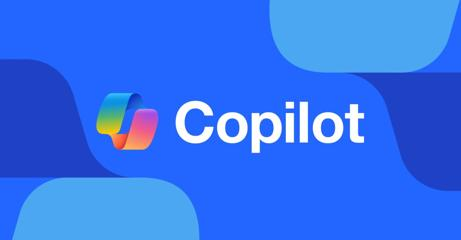

[Microsoft makes computer use available in Copilot Studio](https://www.theverge.com/news/649574/microsoft-copilot-studio-computer-use-ai) - The Verge

___

[Are Dairy Robots the Secret to Happier Cows and More Efficient Farms?](https://spectrum.ieee.org/lely-dairy-robots)

___

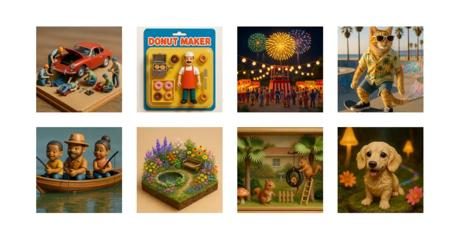

[ChatGPT adds an image library feature, might launch a social networking feature instead of just having everyone post stuff on Facebook, Instagram and Twitter](https://www.digitaltrends.com/computing/chatgpt-adds-image-library/) - Digital Trends

___

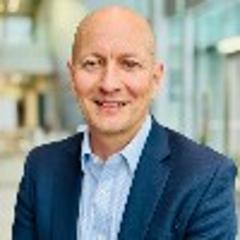

[AI- assisted fake IDs are a growing problem for banks and fintechs](https://www.finextra.com/blogposting/28289/ai-driven-synthetic-fraud-a-growing-threat-to-uk-financial-institutions) - Finextra Research

___

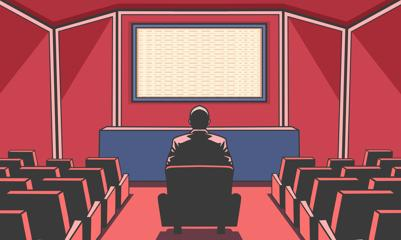

[The Role of Human Creators in an A.I. Ecosystem](https://observer.com/2025/04/the-role-of-human-creators-in-an-a-i-ecosystem/) - Observer

___

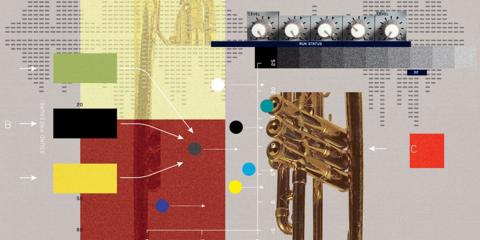

[New diffusion AI models that make songs from scratch are complicating our definitions of authorship and human creativity.](https://www.technologyreview.com/2025/04/16/1114433/ai-artificial-intelligence-music-diffusion-creativity-songs-writer/) - MIT Technology Review

___

[Bad AI Bots Are Taking Over the Web, exceeding human traffic, ByteDance said to be the worst.](https://www.darkreading.com/vulnerabilities-threats/ai-bad-bots-are-taking-over-web)

___

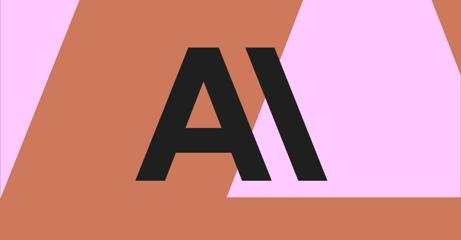

[Anthropic is readying an advanced voice assistant](https://www.theverge.com/news/649175/anthropic-claude-ai-voice-mode-report) - The Verge

___

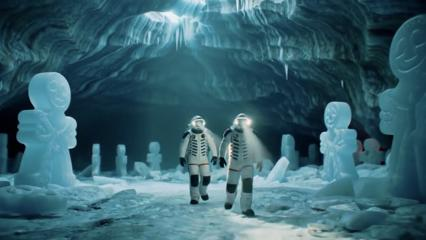

[Google is rolling out Veo 2 video tools to general availablity after lengthy buzzy preview](https://blog.google/products/gemini/video-generation/) - Google

___

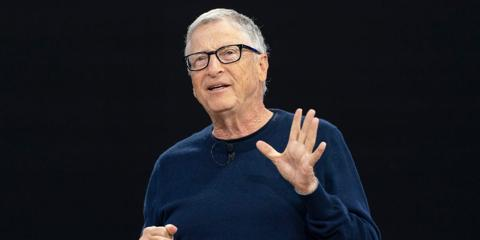

[Bill Gates says AI will reduce shortages of good teachers and doctors](https://www.businessinsider.com/bill-gates-ai-job-shortages-doctors-teachers-work-free-time-2025-4) - Business Insider

___

[Claude adds deep research, Google Worskpace and Gmail integration](https://www.anthropic.com/news/research)

___

[He seems to be saying they created a reinforcement learning algorithm that discovered a better reinforcement learning algorithm than itself and better than any algo humans had ever designed](https://x.com/slow_developer/status/1911907316099916038)

___

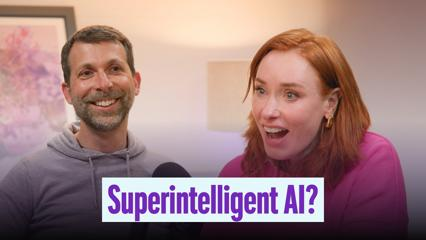

[David Silver and Hannah Fry](https://www.youtube.com/watch?v=zzXyPGEtseI) - YouTube

___

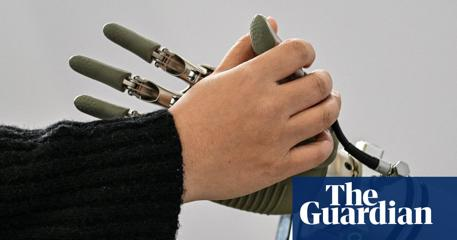

[‘She helps cheer me up’: People form relationships with AI chatbots](https://www.theguardian.com/technology/2025/apr/15/she-helps-cheer-me-up-the-people-forming-relationships-with-ai-chatbots) - the Guardian

___

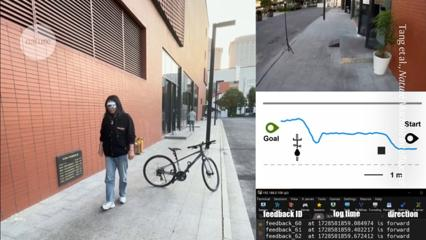

[AI-enabled cameras help blind people navigate](https://www.nature.com/articles/d41586-025-01214-9)

___

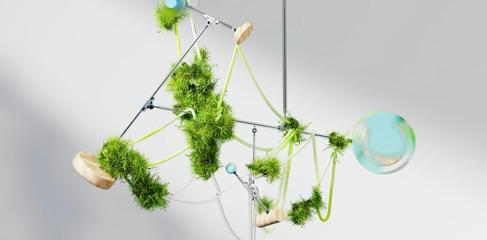

[A weird phrase 'vegetative electron microscopy' is plaguing scientific papers – and we traced it back to a glitch in a pdf scan](https://theconversation.com/a-weird-phrase-is-plaguing-scientific-papers-and-we-traced-it-back-to-a-glitch-in-ai-training-data-254463) - The Conversation

___

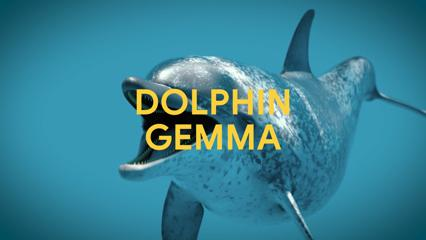

[DolphinGemma: How Google AI is helping decode dolphin communication](https://blog.google/technology/ai/dolphingemma/) - Google

___

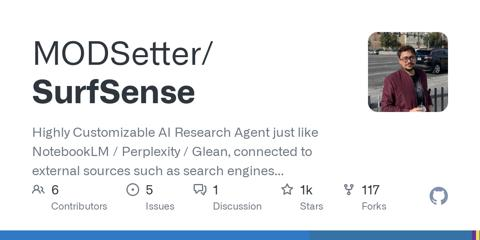

[SurfSense wants to be your locally hosted NotebookLM / Perplexity / Glean, connected to external sources such as search engines, Slack, Notion, YouTube etc](https://github.com/MODSetter/SurfSense) - GitHub

___

[Sme user experiments](https://www.reddit.com/r/ChatGPT/comments/1jzniro/klings_newest_ai_video_model_make_it_hard_to/)

___

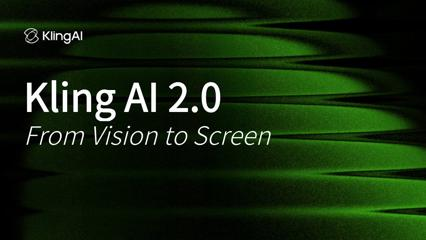

[Kling drops 2.0 text-to-video model](https://www.youtube.com/watch?v=7ihYDVyRYFM) - YouTube

___

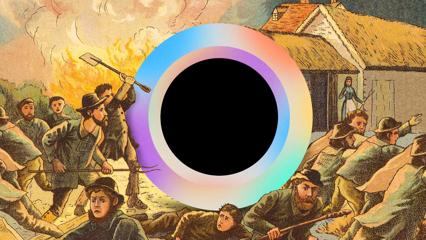

[How to survive the AI revolution. “We would have handled this challenge better in the nineteen-seventies than we are handling it now—and that’s a very sad statement” - David Autor](https://www.newyorker.com/magazine/2025/04/21/how-to-survive-the-ai-revolution) - The New Yorker

___

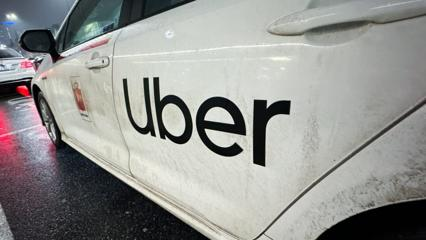

[What can workers do if they’re fired by AI?](https://www.ft.com/content/6ca668c6-60a8-4215-857b-491e74f9599a)

___

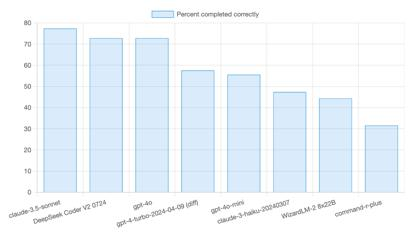

[GPT-4.1 didn't challenge Gemini 2.5 on coding, reasoning o3-mini is still the way to go.](https://aider.chat/docs/leaderboards/) - aider

___

[What ‘Ex Machina’ got right (and wrong) about AI, 10 years later](https://www.fastcompany.com/91316450/what-ex-machina-got-right-and-wrong-about-ai-10-years-later)

___

[Meetings Won’t Be the Same When the Boss Sends an AI Bot](https://www.bloomberg.com/news/features/2025-04-15/meetings-won-t-be-the-same-when-the-ceo-sends-an-ai-bot)

___

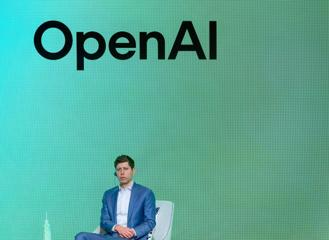

[OpenAI plans to phase out GPT-4.5 from its API in July. We'll wait for 3rd-party benchmarks but presumably 4.1 is better and cheaper.](https://techcrunch.com/2025/04/14/openai-plans-to-wind-down-gpt-4-5-its-largest-ever-ai-model-in-its-api/) - TechCrunch

___

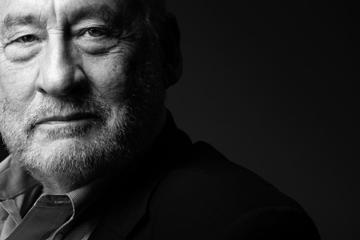

[Joseph Stiglitz Warns Of The Looming Inequality Amid AI Monopoly Power](https://www.forbes.com/sites/hessiejones/2025/04/13/joseph-stiglitz-warns-of-the-looming-inequality-amid-ai-monopoly-power/) - Forbes

___

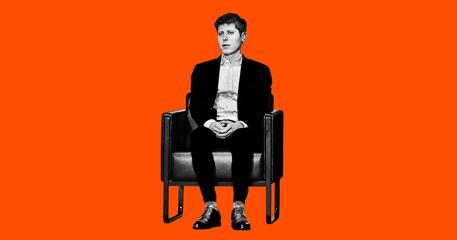

[Former OpenAI Employee Rages Against Sam Altman: "Person of Low Integrity"](https://futurism.com/the-byte/former-openai-employee-altman) - Futurism

___

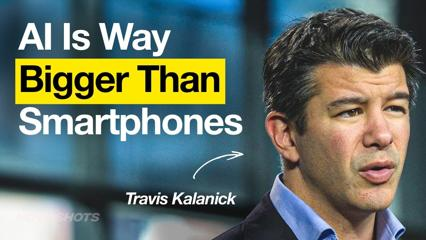

[Travis Kalanick says some consultants might be in trouble. I wonder about the WITCH offshore dev platforms. (Wipro, Infosys, Tata, Cognizant, HCL)](https://www.youtube.com/watch?v=IAGHlZpSbMs) - YouTube

___

[MIT economics professor Sendhil Mullainathan says it is in humans’ power to put artificial intelligence on a path to help us rather than replace us.](https://www.wsj.com/tech/ai/ai-jobs-mit-sendhil-mullainathan-135ad2b7)

___

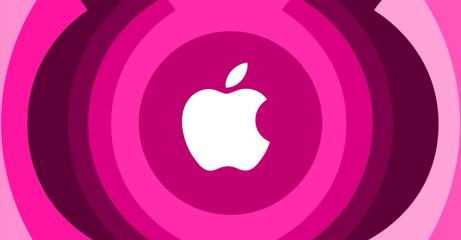

[Apple plans to collect user data about AI usage with differential privacy](https://www.theverge.com/news/648496/apple-improve-ai-models-differential-privacy) - The Verge

___

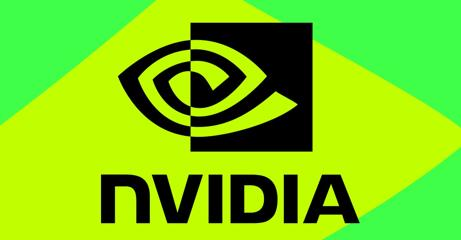

[Nvidia starts producing its Blackwell AI chip at TSMC’s Arizona plant, partners with Foxconn and Wistron to build servers and rack-scale interconnected pods in Texas, plans to build a couple of percentage points of GDP worth over the next few years.](https://www.theverge.com/news/648086/nvidia-blackwell-ai-tsmc-arizona-plant) - The Verge

___

[OpenAI launches GPT-4.1, says it's better and 26% cheaper than 4o](https://openai.com/index/gpt-4-1/)

___

[This exhibit is closed temporarily for maintenance](https://www.reddit.com/r/aivideo/s/lrFgc6CUeK)

___

[GPT 4.1 and o3 expected this week. I wonder if they will rejigger the model selector in the UI which is getting pretty confusing and 3 or 4 more models is a lot.](https://www.bleepingcomputer.com/news/artificial-intelligence/openais-gpt-41-41-nano-and-41-mini-models-release-imminent/)

___

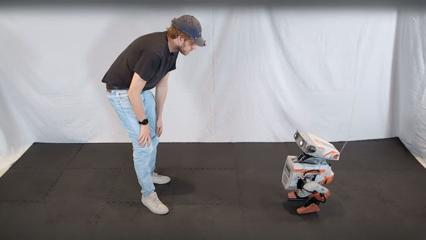

[Disney imagineers an AI humanoid robot to mimic human emotions and behavior](https://www.foxnews.com/tech/ai-humanoid-robot-learns-mimic-human-emotions-behavior) - Fox News

___

[Tariffs are bad for growth after 30 years of globalizing supply chains and trade reaching 60% of global GDP. Worse if they are arbitrary and change daily. Is it good or bad that big companies and people who pay for Mar-a-Lago meetings can buy their way out of tariffs and taxes and investigations?](https://www.bloomberg.com/news/articles/2025-04-13/apple-was-on-brink-of-crisis-before-tariff-concession-from-trump?fromMostRead=true)

___

[AI isn't 'just a tool', the medium is the message](https://www.fastcompany.com/91315558/sorry-folks-but-ai-isnt-just-a-tool)

___

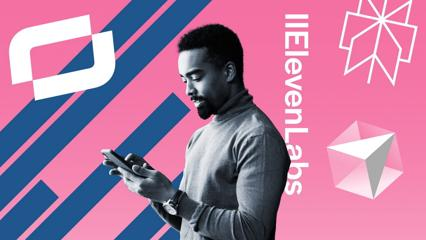

[AI ‘application’ start-ups become big businesses in new tech race](https://www.ft.com/content/fd6a895e-d296-4dab-9aab-15a1559ea054)

___

Everything is a wrapper

[2 year of progress with AI video](https://www.reddit.com/r/ThatsInsane/comments/1jyja0s/2_years_difference_makes_you_wonder_where_ai_will/)

___

[Using the shroud of Turin as a Midjourney prompt to generate an image of Jesus.](https://x.com/mvaneerde/status/1829237643915473102)

___

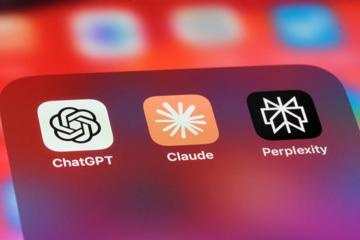

[International students seen as big beneficiaries of AI](https://www.kqed.org/mindshift/65411/who-are-the-biggest-early-beneficiaries-of-chatgpt-international-students)

___

[Many teachers embrace AI, while worrying about how students use it.](https://www.nytimes.com/2025/04/14/us/schools-ai-teachers-writing.html)

___

Follow the latest AI headlines via [SkynetAndChill.com on Bluesky](https://bsky.app/profile/skynetandchill.com)

In [11]:
imgdir = 'tmp'  # for images
delete_files(imgdir)

display(Markdown("\n x <br /> \n"))

display(Markdown("\n <br /> \n"))

for i, post in enumerate(data.feed):


    # check date
    date_str = data.feed[0].post.record.created_at
    dt = datetime.fromisoformat(date_str.rstrip('Z'))
    # break if more than 30 hours ago
    if dt  < datetime.now() - timedelta(hours=30):
        break
    
    post_str = post.post.record.text.rstrip()
    post_str = truncate_last_occurrence(post_str)
    post_url = ""
    tag_dict = {}
    try:
        post_url = post.post.record.embed.external.uri.rstrip()
    except:
        pass
    if post_url:
        tag_dict = dict()
        try:
            tag_dict = get_og_tags(post_url)
        except:
            pass
        display_str = f"[{post_str}]({post_url})"
        site_name = tag_dict.get('og:site_name')
        img_url = tag_dict.get('og:image')
        if site_name:
            display_str += f" - {site_name}"

        display_str = display_str.replace("$", "\\\$")  # so Markdown doesn't interpret $ as latex escape
        if img_url:
            try:
                r = rawfetchurl(img_url)
                content_type = r.headers['Content-Type']
                content_type = content_type[content_type.find('/')+1:]
                impath = f"{imgdir}/source{i}.{content_type}"
                with open(impath, 'wb') as file:
                    file.write(r.content)
                output_path = f'{imgdir}/Image{i}.jpg'
                resize_and_crop(impath, output_path)
                display(IPython.display.Image(filename=output_path))
            except Exception as e:
                print(e)
        display(Markdown(display_str))
        display(Markdown("___"))

    else:
        display(Markdown(f"{post_str}"))

display(Markdown(f"Follow the latest AI headlines via [SkynetAndChill.com on Bluesky](https://bsky.app/profile/skynetandchill.com)"))

        

In [12]:
print(datetime.now())

2025-04-16 09:52:17.053448


In [13]:
date_str = data.feed[0].post.record.created_at
dt = datetime.fromisoformat(date_str.rstrip('Z'))
dt

datetime.datetime(2025, 4, 16, 13, 43, 6, 551000)

In [14]:

# Get the current datetime
now = datetime.now()

# Create a timedelta of 30 hours
delta = timedelta(hours=30)

# Subtract 30 hours from the current datetime
thirty_hours_ago = now - delta

print(thirty_hours_ago)


2025-04-15 03:52:17.066860


In [15]:
from typing import TypedDict, Annotated

class Point2D(TypedDict, total=False):
    x: int
    y: int
    label: str

a: Point2D = {'x': 1, 'y': 2, }  # 


In [16]:
a

{'x': 1, 'y': 2}

In [17]:
b



NameError: name 'b' is not defined

In [ ]:
```mermaid
flowchart LR

A[Hard] -->|Text| B(Round)
B --> C{Decision}
C -->|One| D[Result 1]
C -->|Two| E[Result 2]
